# Intro

## Installs

In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM 
%cd LightGBM 
!mkdir build
%cd build
!cmake -DUSE_GPU=1 ..
!make -j4
!pip uninstall lightgbm
!cd ../python-package/ && python setup.py install
!pip install sklego
!pip install xgboost --upgrade

Cloning into 'LightGBM'...
remote: Enumerating objects: 26830, done.
remote: Counting objects: 100% (3753/3753), done.
remote: Compressing objects: 100% (327/327), done.
remote: Total 26830 (delta 3574), reused 3496 (delta 3422), pack-reused 23077
Receiving objects: 100% (26830/26830), 19.25 MiB | 22.97 MiB/s, done.
Resolving deltas: 100% (19911/19911), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
remot

In [ ]:
%cd ../../

## Imports

In [ ]:
import os, gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from lightgbm import LGBMClassifier

import xgboost as xgb

from sklego.mixture import BayesianGMMClassifier

from drive.MyDrive.Kaggle.Clustering_072022.src import functions

import warnings # suppress warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Configs

In [ ]:
class CFG:
    path = 'drive/MyDrive/Kaggle/Clustering_072022/'
    seed = 42
    clusters = 7
    splits = 5
    thresh = 0.85

## Loading & Transforming Data

In [ ]:
data = pd.read_csv(CFG.path + 'src/data_removed.csv', index_col='id')

best_cols = data.columns
cat_feats = data.columns[data.dtypes == 'int'].tolist()
num_feats = data.columns[data.dtypes == 'float'].tolist()

data[num_feats] = RobustScaler().fit_transform(data[num_feats])
df_scaled = pd.DataFrame(PowerTransformer().fit_transform(data), columns=data.columns)

In [ ]:
functions.set_seed(0)

pred_probs = functions.soft_voting(10, df_scaled, best_cols, with_replace=True, max_iter=300, tol=0.01)
pickle.dump(pred_probs, open(CFG.path+'src/ensemble_pkls/E#3#1pred_probs.pkl', 'wb'))
# pred_probs = pickle.load(open(CFG.path+'src/E#2pred_probs_n50.pkl', 'rb'))

========= 0 ==========
David Bouldin score: 3.6296
Calinski Harabasz score: 3802.630
========= 1 ==========
David Bouldin score: 3.6295
Calinski Harabasz score: 3802.482
========= 2 ==========
David Bouldin score: 3.6325
Calinski Harabasz score: 3801.973
========= 3 ==========
David Bouldin score: 3.6275
Calinski Harabasz score: 3803.808
========= 4 ==========
David Bouldin score: 3.6287
Calinski Harabasz score: 3800.995
========= 5 ==========
David Bouldin score: 3.6226
Calinski Harabasz score: 3804.762
========= 6 ==========
David Bouldin score: 3.6221
Calinski Harabasz score: 3803.259
========= 7 ==========
David Bouldin score: 3.6224
Calinski Harabasz score: 3804.537
========= 8 ==========
iteration 8 could not determine the cluster label mapping, skipping
========= 9 ==========
David Bouldin score: 3.6186
Calinski Harabasz score: 3803.551


In [ ]:
%%time
functions.score_clusters(df_scaled[best_cols], pred_probs.idxmax(axis=1), verbose=True, silhouette=False)

David Bouldin score: 3.6300
Calinski Harabasz score: 3811.295
CPU times: user 206 ms, sys: 165 ms, total: 370 ms
Wall time: 191 ms


(3.629954291477039, 3811.2948347679885)

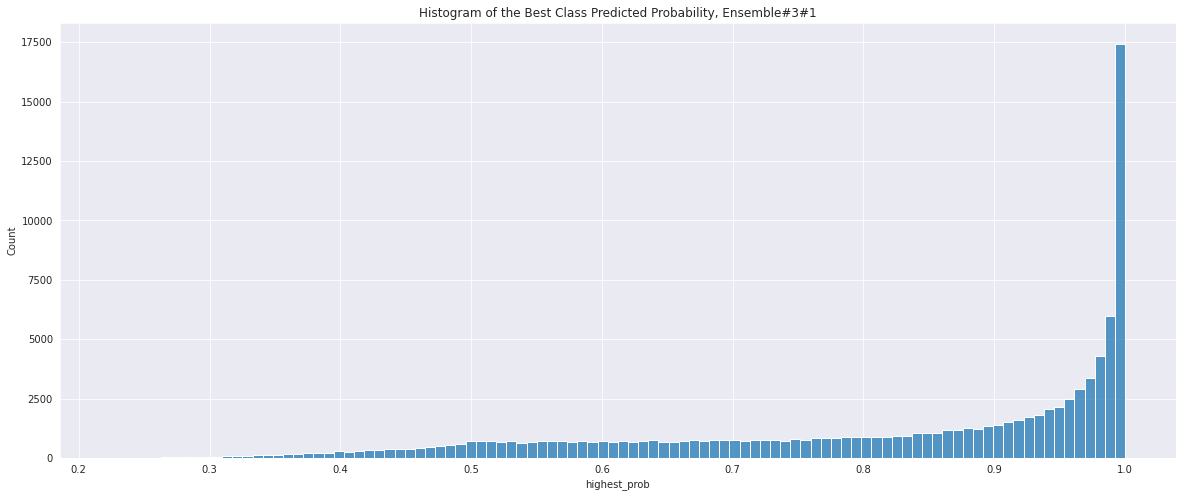

In [ ]:
cluster_class_probs = functions.best_class(pred_probs)
plt.figure(figsize=(20, 8))
sns.histplot(cluster_class_probs['highest_prob'], bins=100)
plt.title('Histogram of the Best Class Predicted Probability, Ensemble#3#1')
plt.show()

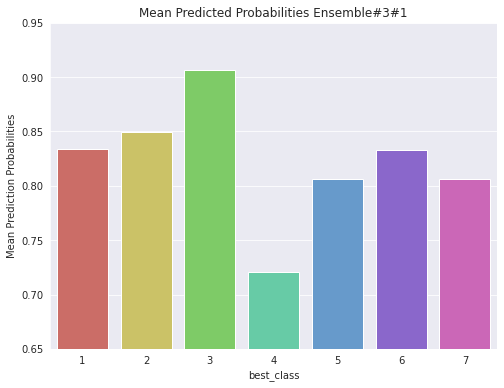

In [ ]:
confidence_s = cluster_class_probs.groupby('best_class')['highest_prob'].mean()
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=confidence_s.index, y=confidence_s.values, palette=sns.color_palette('hls', 7))
ax.set_ylabel('Mean Prediction Probabilities')
ax.set_ylim([0.65, 0.95])
plt.title('Mean Predicted Probabilities Ensemble#3#1')
plt.show()

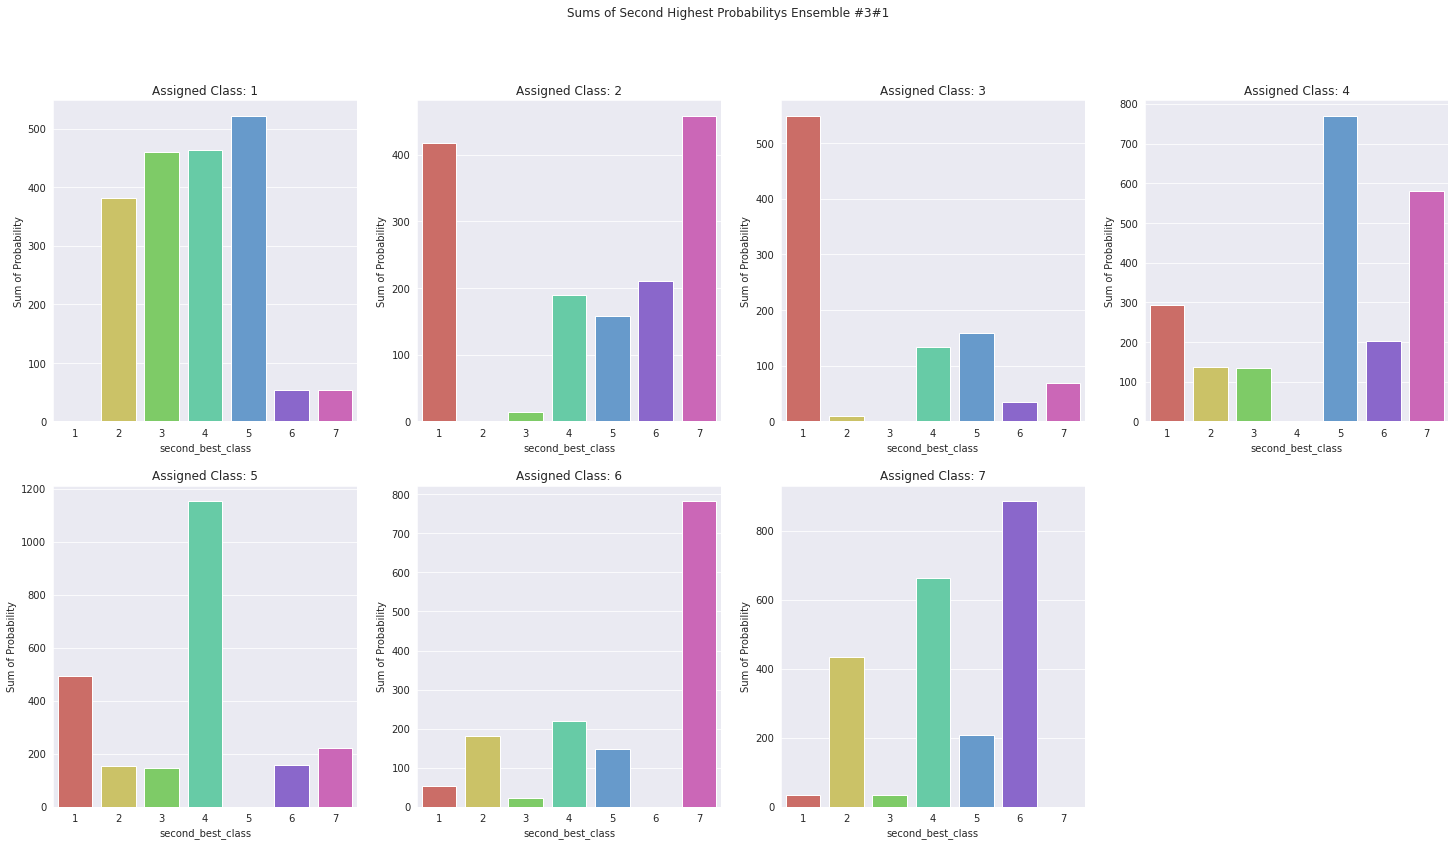

In [ ]:
functions.second_highest(cluster_class_probs, 'Sums of Second Highest Probabilitys Ensemble #3#1')

# Confidence Threshold Filtering

In [ ]:
confident_predictions = cluster_class_probs.loc[cluster_class_probs['highest_prob'] >= CFG.thresh]
confident_preds_class = confident_predictions['best_class']
df_scaled['class'] = confident_preds_class

train_df = df_scaled.loc[df_scaled["class"] == df_scaled["class"]]
test_df = df_scaled.loc[df_scaled["class"] != df_scaled["class"]]

X = train_df.drop(columns="class").reset_index(drop=True)
y = train_df["class"].reset_index(drop=True)
X_test = test_df.drop(columns="class").reset_index(drop=True)
X_full = df_scaled.drop(columns="class")

# Model Definitions

In [ ]:
params_xgb = {
    'booster': 'gbtree',
    'learning_rate': 4e-2,
    'num_class': 7,
    'seed': CFG.seed,
    'gpu_id': 0,
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor',
    'num_boost_round' : 20000,
    'early_stopping_rounds' : 200
    }

In [ ]:
et = ExtraTreesClassifier(n_estimators = 2000,
                                n_jobs = -1,
                                random_state=CFG.seed
                               )

lgb = LGBMClassifier(objective = 'multiclass',
                            n_estimators = 5000,
                            random_state = CFG.seed,
                            learning_rate = 0.1,
                            n_jobs = -1,
                            device_type='gpu')

qda = QuadraticDiscriminantAnalysis()

lda = LinearDiscriminantAnalysis()

bgmm = BayesianGMMClassifier(
            n_components=CFG.clusters,
            random_state = CFG.seed,
            tol =1e-3,
            covariance_type = 'full',
            max_iter = 400,
            n_init=4,
            init_params='kmeans')

xgbc = xgb.XGBClassifier(params_xgb, objective='multi:softprob')

svc = SVC(probability=True)

In [ ]:
models = {"ET":et, "LGBM":lgb, "QDA":qda, "LDA":lda, "BGMM_C":bgmm, "SVC": svc, "XGB": xgbc} 

# Kfold Classification

In [ ]:
def evaluate_models():
    for model_name, model in models.items():
        print(f'==='*10, model_name, '==='*10)
        feat_imp, y_pred_list, y_true_list, acc_list, X_val, y_val = functions.k_fold_cv(model=model, X=X, y=y, n_splits=2, model_name=model_name, verbose=True)
        acc_score = accuracy_score(y_pred_list, y_true_list)
        print('{0:0.4f}'.format(acc_score))
        gc.collect()

In [ ]:
evaluate_models()

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

# Predict Everything

In [ ]:
def fit_predict_everything():
    preds = []
    model_names = []
    scores = []
    for model_name, model in models.items():
        print('===', model_name, '===')

        if model_name == 'XGB':
            xy = y.astype(int)-1
            model.fit(X[best_cols], xy)
            preds_prob = model.predict_proba(X_full[best_cols])
        else:
            model.fit(X[best_cols], y)
            preds_prob = model.predict_proba(X_full[best_cols])

        preds_prob_df = pd.DataFrame(preds_prob, columns=range(1, 8), index=df_scaled.index)
        db, ch = functions.score_clusters(df_scaled[best_cols], preds_prob_df.idxmax(axis=1), verbose=True)
        scores.append((db, ch))
        preds.append(preds_prob_df)
        model_names.append(model_name)

    return preds, model_names, scores

In [ ]:
predictions, model_names, scores = fit_predict_everything()

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
cluster_class_probs = cluster_class_probs.loc[:, [1, 2, 3, 4, 5, 6, 7]]
predictions.append(cluster_class_probs)
model_names.append('BGMM')

db, ch = functions.score_clusters(df_scaled[best_cols], cluster_class_probs.idxmax(axis=1), verbose=True)
scores.append((db, ch))

David Bouldin score: 3.6186
Calinski Harabasz score: 3803.551


# Combine Predictions

In [ ]:
pred_dict = dict(zip(model_names, predictions))
pickle.dump(pred_dict, open(CFG.path+'src/E#3#1pred_dict.pkl', 'wb'))

In [ ]:
#chosen fairly randomly
predictions_df = 0.5 * pred_dict['ET'] + 1.5 * pred_dict['LGBM'] + 0.5 * pred_dict['QDA'] + 1.5 * pred_dict['BGMM_C'] + 0.5 * pred_dict['BGMM'] + 0.5 * pred_dict['SVC']  + 1.5 * pred_dict['XGB']

#normalise so rows sums to 1
predictions_df = predictions_df.div(predictions_df.sum(axis=1), axis=0)
predictions_df = functions.best_class(predictions_df)
pickle.dump(predictions_df, open(CFG.path+'src/E#3#1pred_df.pkl', 'wb'))

# Analyze Predicted

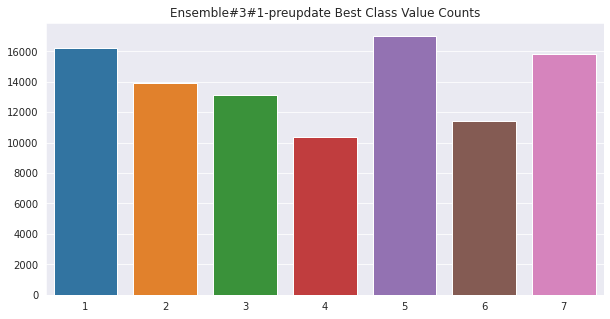

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
val_c = predictions_df["best_class"].value_counts()
sns.barplot(x=val_c.index, y=val_c.values)
plt.title('Ensemble#3#1-preupdate Best Class Value Counts')
plt.show()

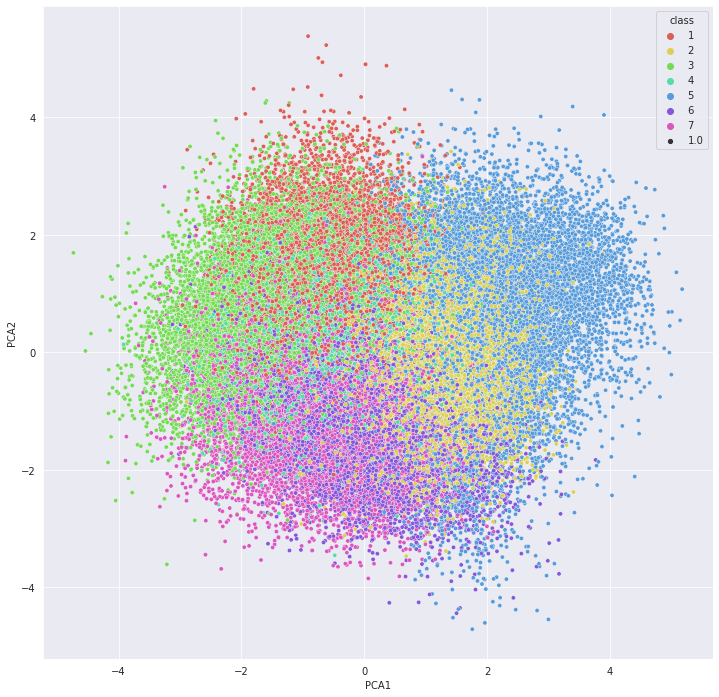

In [ ]:
pca = PCA(n_components=2, random_state=10)
X_pca = pca.fit_transform(df_scaled[best_cols])
pca_df = pd.DataFrame({'PCA1': X_pca[:, 0], 'PCA2': X_pca[:, 1]})
pca_df['class'] = predictions_df['best_class']

fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='class', s=2, palette=sns.color_palette('hls', pca_df['class'].nunique()), size=np.ones(pca_df.shape[0]))

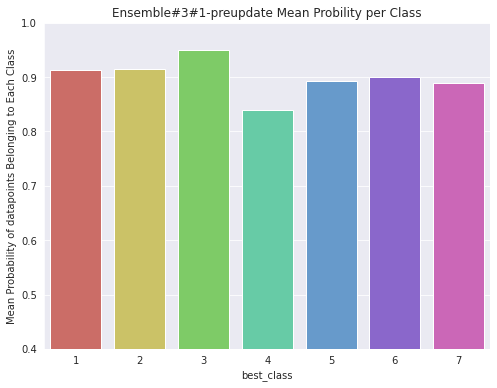

In [ ]:
confidence_s = predictions_df.groupby('best_class')['highest_prob'].mean()
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=confidence_s.index, y=confidence_s.values, palette=sns.color_palette('hls', 7))
ax.set_ylabel('Mean Probability of datapoints Belonging to Each Class')
ax.set_ylim([0.4, 1.])
plt.title('Ensemble#3#1-preupdate Mean Probility per Class')
plt.show()

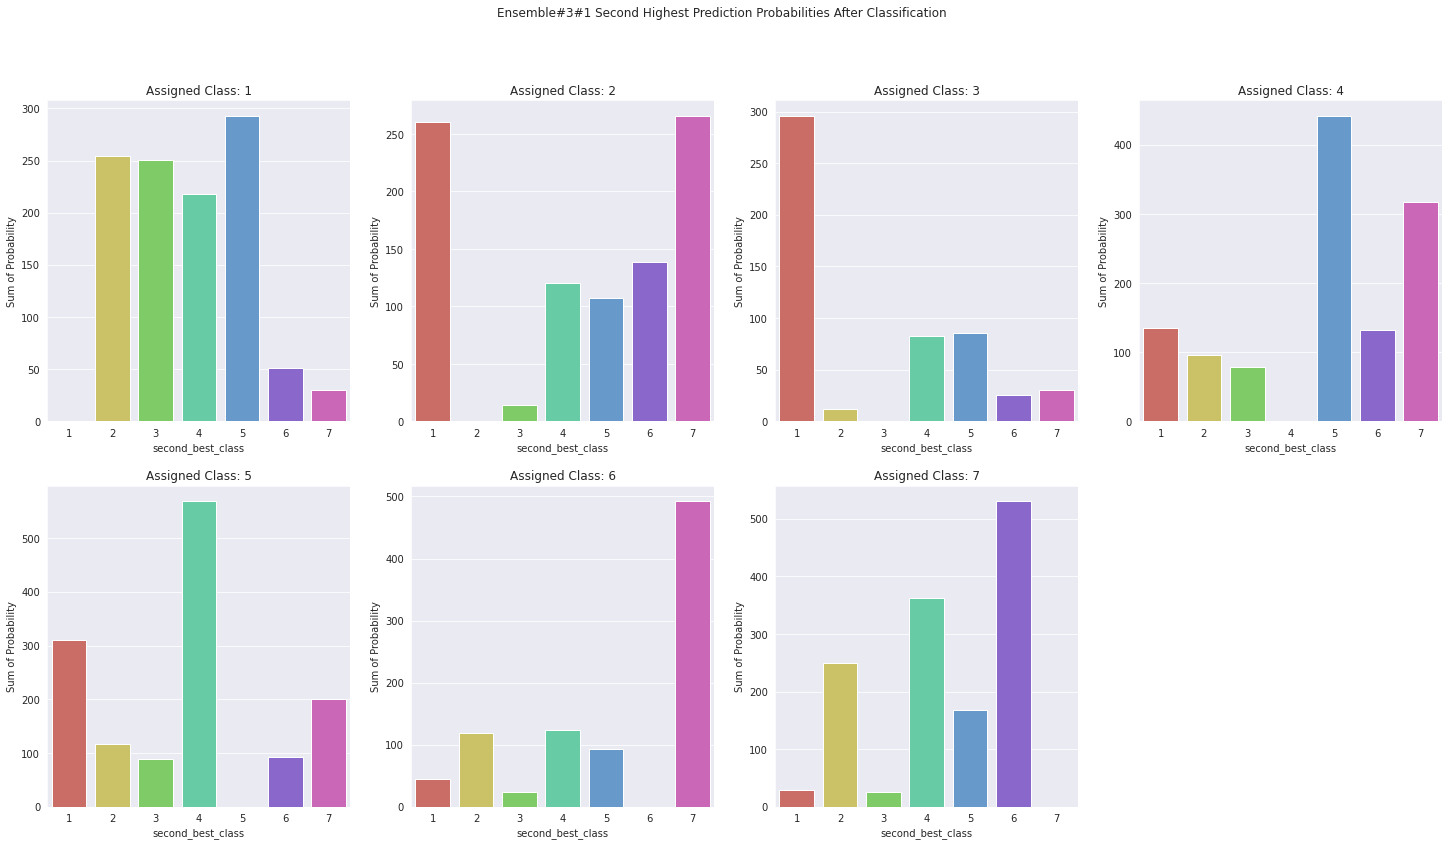

In [ ]:
functions.second_highest(predictions_df, 'Ensemble#3#1 Second Highest Prediction Probabilities After Classification')

# Update Predictions

In [ ]:
def update_predictions(predict_number, y):
    for i in range(predict_number):
        print('==='*6, i, '==='*6)
        X_scaled_sample = df_scaled.sample(50000)
        y_sample = y.loc[X_scaled_sample.index]

        bgmm = BayesianGMMClassifier(
            n_components=7,
            random_state=i,
            n_init=3, max_iter=300,
            tol=0.001,
            init_params='kmeans'
        )
        bgmm.fit(X_scaled_sample[best_cols], y_sample)

        pred_probs = bgmm.predict_proba(df_scaled[best_cols])
        pred_probs = pd.DataFrame(pred_probs, columns=range(1,8))

        functions.score_clusters(df_scaled[best_cols], pred_probs.idxmax(axis=1), verbose=True)
        y = pred_probs.idxmax(axis=1)

    return pred_probs

In [ ]:
predicted_probabilities = update_predictions(predict_number=10, y=predictions_df["best_class"])

================== 0 ==================
David Bouldin score: 3.8261
Calinski Harabasz score: 3575.585
================== 1 ==================
David Bouldin score: 3.8417
Calinski Harabasz score: 3562.341
================== 2 ==================
David Bouldin score: 3.8416
Calinski Harabasz score: 3560.780
================== 3 ==================
David Bouldin score: 3.8547
Calinski Harabasz score: 3553.272
================== 4 ==================
David Bouldin score: 3.8561
Calinski Harabasz score: 3550.471
================== 5 ==================
David Bouldin score: 3.8637
Calinski Harabasz score: 3547.471
================== 6 ==================
David Bouldin score: 3.8659
Calinski Harabasz score: 3544.745
================== 7 ==================
David Bouldin score: 3.8726
Calinski Harabasz score: 3544.206
================== 8 ==================
David Bouldin score: 3.8722
Calinski Harabasz score: 3543.935
================== 9 ==================
David Bouldin score: 3.8705
Calinski Harab

In [ ]:
predictions_df = functions.best_class(predicted_probabilities)

# Updated Predictions Analysis

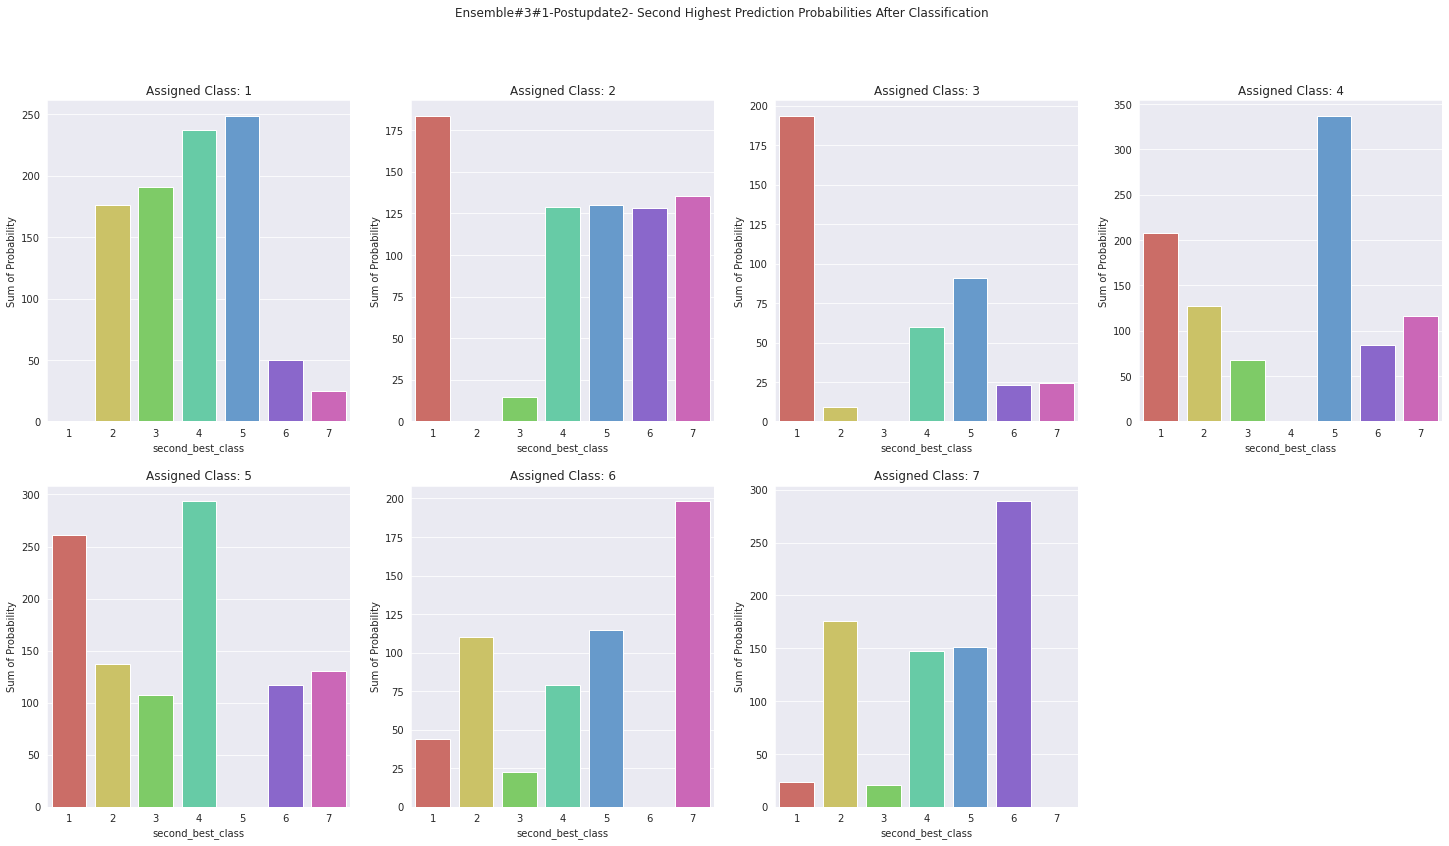

In [ ]:
functions.second_highest(predictions_df, 'Ensemble#3#1-Postupdate2- Second Highest Prediction Probabilities After Classification')

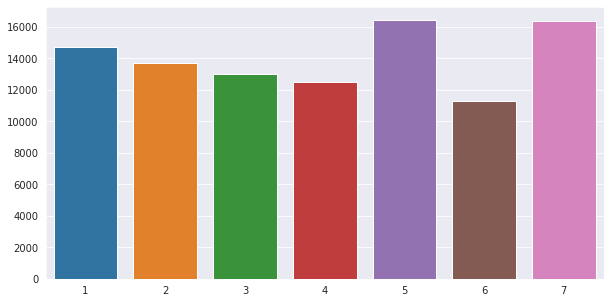

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
val_c = predictions_df['best_class'].value_counts()
sns.barplot(x=val_c.index, y=val_c.values)

In [ ]:
submission = pd.read_csv(CFG.path + 'submissions/sample_submission.csv', index_col='Id')
submission['Predicted'] = predictions_df['best_class']
submission.to_csv(CFG.path + 'submissions/ensemble#3#1-afterupdate2(5).csv')

In [ ]:
submission['Predicted'] = preds['best_class']
submission.to_csv(CFG.path + 'submissions/Ensemble#2#2#4-afterupdate.csv')
# submission['Predicted'] = pred_probs.idxmax(axis=1)
# submission.to_csv(CFG.path + 'submissions/Ensemble#2#1original_proba_preds.csv')

In [ ]:
preds = pickle.load(open(CFG.path+'src/E#2pred_df#1.pkl', 'rb'))

In [ ]:
for name, preds in pred_dict.items():
    print(name, preds)
    break

ET             1       2       3       4       5       6       7
0      0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000
1      0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000
2      0.0245  0.2360  0.0200  0.0185  0.0015  0.0490  0.6505
3      0.0030  0.1165  0.0155  0.0150  0.7800  0.0670  0.0030
4      0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000
...       ...     ...     ...     ...     ...     ...     ...
97995  0.0350  0.2745  0.1010  0.1220  0.0320  0.3415  0.0940
97996  0.0735  0.0030  0.5235  0.0810  0.0000  0.3125  0.0065
97997  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000
97998  0.4470  0.1980  0.0285  0.1215  0.1695  0.0075  0.0280
97999  0.1420  0.0005  0.5785  0.0075  0.0010  0.0085  0.2620

[98000 rows x 7 columns]
